## Word2vec model

Word2Vec is one of the most popular and more advanced techniques for learning word embeddings. This technique is based on the assumption that words in the same contexts usually have similar meanings. Word embedding is a vector representation of a word and its input is the text corpus, and its output is a set of vectors. Word embeddings using word2vec can make natural language readable for the computer, and then one can apply further implementation of mathematical operations on words to detect their similarity. A well-trained set of word vectors will place similar words close together in this space.

In this project, I would like to show how to use the Gensim implementation of Word2Vec by using python with an example of generating word embedding for the make-up products model.
This dataset include such features as name of product, description and tags. I used these functions to generate word embedding for each those example and then compare similarities between them. Before I started generate Word2vec model I had to pre-process data. I applied process in which sentences are converted to a list of words, removed stopwords and  applied lemmatizing. Then I created Word2Vec model for each example. Finally I used T-SNE to visualize received word embeddings. 


### Importing packages and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("darkgrid")

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess
from gensim.models import phrases, word2vec, Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('C:\\Python Scripts\\API_products\\products_final.csv', header=0,index_col=0)
df.head()

,brand,category,currency,description,id,name,price,price_sign,product_type,rating,tag_list
0,colourpop,pencil,CAD,Lippie Pencil A long-wearing and high-intensit...,1048,Lippie Pencil,5.0,$,lip_liner,NaN,"['Vegan', 'cruelty free']"
1,colourpop,lipstick,CAD,Blotted Lip Sheer matte lipstick that creates ...,1047,Blotted Lip,5.5,$,lipstick,NaN,"['Vegan', 'cruelty free']"
2,colourpop,lipstick,CAD,"Lippie Stix Formula contains Vitamin E, Mango,...",1046,Lippie Stix,5.5,$,lipstick,NaN,"['Vegan', 'cruelty free']"
3,colourpop,liquid,CAD,"Developed for the Selfie Age, our buildable fu...",1045,No Filter Foundation,12.0,$,foundation,NaN,"['Vegan', 'cruelty free']"
4,boosh,lipstick,CAD,All of our products are free from lead and hea...,1044,Lipstick,26.0,$,lipstick,NaN,"['Organic', 'Chemical Free']"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 930
Data columns (total 11 columns):
brand           919 non-null object
category        507 non-null object
currency        368 non-null object
description     906 non-null object
id              931 non-null int64
name            931 non-null object
price           917 non-null float64
price_sign      368 non-null object
product_type    931 non-null object
rating          340 non-null float64
tag_list        931 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 87.3+ KB


In [5]:
df.shape

(931, 11)

### Data Preparation 

In [7]:
text = df.drop(['product_type', 'currency', 'id', 'price', 'price_sign', 'rating', 'brand', 'category'], axis=1)

In [8]:
text.head()

,description,name,tag_list
0,Lippie Pencil A long-wearing and high-intensit...,Lippie Pencil,"['Vegan', 'cruelty free']"
1,Blotted Lip Sheer matte lipstick that creates ...,Blotted Lip,"['Vegan', 'cruelty free']"
2,"Lippie Stix Formula contains Vitamin E, Mango,...",Lippie Stix,"['Vegan', 'cruelty free']"
3,"Developed for the Selfie Age, our buildable fu...",No Filter Foundation,"['Vegan', 'cruelty free']"
4,All of our products are free from lead and hea...,Lipstick,"['Organic', 'Chemical Free']"


In [9]:
text['description'] = text['description'].astype(str)
text['tag_list'] = text['tag_list'].astype(str)
text['name'] = text['name'].astype(str)

In [10]:
text.isnull().sum()

description    0
name           0
tag_list       0
dtype: int64

#### Text preprocessing

We are removing non-alphabetic characters, the stopwords and lemmatizing for each line of text.

In [11]:
# This function converts a text to a sequence of words:
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ",words)
    text = words.lower().split()
    return " ".join(text)

In [12]:
text['description'] = text['description'].apply(tokens)
text['tag_list'] = text['tag_list'].apply(tokens)
text['name'] = text['name'].apply(tokens)
text.head()

,description,name,tag_list
0,lippie pencil a long wearing and high intensit...,lippie pencil,vegan cruelty free
1,blotted lip sheer matte lipstick that creates ...,blotted lip,vegan cruelty free
2,lippie stix formula contains vitamin e mango a...,lippie stix,vegan cruelty free
3,developed for the selfie age our buildable ful...,no filter foundation,vegan cruelty free
4,all of our products are free from lead and hea...,lipstick,organic chemical free


#### StopWords

We extracting the stopwords from nltk library, then we build function to remove stop words:

In [13]:
# Show some stop words
stop = stopwords.words('english')
stop[0:10]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

In [15]:
text['description'] = text['description'].apply(stopwords)
text['name'] = text['name'].apply(stopwords)
text.head()

,description,name,tag_list
0,lippie pencil long wearing high intensity lip ...,lippie pencil,vegan cruelty free
1,blotted lip sheer matte lipstick creates perfe...,blotted lip,vegan cruelty free
2,lippie stix formula contains vitamin e mango a...,lippie stix,vegan cruelty free
3,developed selfie age buildable full coverage n...,filter foundation,vegan cruelty free
4,products free lead heavy metals parabens phtha...,lipstick,organic chemical free


We build the function to apply lemmatizing:

In [16]:
lem = WordNetLemmatizer()

def word_lem(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

In [17]:
text['description']  = text['description'].apply(word_lem)
text.head()

,description,name,tag_list
0,lippie pencil long wearing high intensity lip ...,lippie pencil,vegan cruelty free
1,blotted lip sheer matte lipstick creates perfe...,blotted lip,vegan cruelty free
2,lippie stix formula contains vitamin e mango a...,lippie stix,vegan cruelty free
3,developed selfie age buildable full coverage n...,filter foundation,vegan cruelty free
4,product free lead heavy metal parabens phthala...,lipstick,organic chemical free


In [18]:
text['description'][1]

'blotted lip sheer matte lipstick creates perfect popsicle pout formula lightweight matte buildable light medium coverage'

## Model creation

### Word2vec for name

Lets try to use simple_preprocess method, which convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

In [51]:
corpus = text['name'].map(simple_preprocess)

In [52]:
corpus[0:10]

0                         [lippie, pencil]
1                           [blotted, lip]
2                           [lippie, stix]
3                     [filter, foundation]
4                               [lipstick]
5                      [serum, foundation]
6                   [coverage, foundation]
7                          [liquid, liner]
8                              [eyeshadow]
9    [realist, invisible, setting, powder]
Name: name, dtype: object

We can train the genism word2vec model with our own custom corpus as following:

In [53]:
name_model = Word2Vec(corpus, size=100, window=3, min_count=1)

C:\Users\PC\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [54]:
# This will print the most similar words present in the model:
name_model.wv.most_similar('lipstick')

[('rose', 0.3261679410934448),
 ('maybelline', 0.30425405502319336),
 ('express', 0.30156373977661133),
 ('long', 0.2996756434440613),
 ('bronzer', 0.2945731580257416),
 ('nail', 0.29042112827301025),
 ('flat', 0.29022955894470215),
 ('flexible', 0.28989794850349426),
 ('nude', 0.2737104594707489),
 ('million', 0.27251937985420227)]

In [55]:
name_model.wv.most_similar('liquid')

[('stick', 0.3793315291404724),
 ('metals', 0.33757591247558594),
 ('contour', 0.31963130831718445),
 ('boudoir', 0.3114571273326874),
 ('addict', 0.3113562762737274),
 ('rouge', 0.29319578409194946),
 ('brilliant', 0.2928236722946167),
 ('gel', 0.28807365894317627),
 ('resistant', 0.280072420835495),
 ('fail', 0.27691227197647095)]

In [56]:
name_model.wv.most_similar('pencil')

[('spectrum', 0.31646865606307983),
 ('radiance', 0.3039230406284332),
 ('transforming', 0.30042147636413574),
 ('muse', 0.29501938819885254),
 ('matte', 0.2898262143135071),
 ('paris', 0.28061944246292114),
 ('kohl', 0.27684545516967773),
 ('cushion', 0.2622339725494385),
 ('plumping', 0.25422000885009766),
 ('exposure', 0.253739595413208)]

### Word2vec model for description

In [21]:
# We create the list of list format of the custom corpus for gensim modeling:
sentences = [row.split() for row in text['description']]

In [22]:
sentences[0:1]

[['lippie',
  'pencil',
  'long',
  'wearing',
  'high',
  'intensity',
  'lip',
  'pencil',
  'glide',
  'easily',
  'prevents',
  'feathering',
  'many',
  'lippie',
  'stix',
  'coordinating',
  'lippie',
  'pencil',
  'designed',
  'compliment',
  'perfectly',
  'feel',
  'free',
  'mix',
  'match']]

##### Creating the model and setting values for the various parameters:

Here are few important of the hyperparameters of this model:
- size: this is the number of dimensions of the embeddings. Typical numbers is in the range of 50 to 300, we use 100 beacause we don't have that much text.
- window: it is the maximum distance between a target word and words around the target word.
- min_count:  minimum count of words to consider when training the model. Words with occurrence less than this count will be ignored. We used for min_count 1.

In [23]:
model = Word2Vec(sentences, min_count=1, size=100, window=3)

C:\Users\PC\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [24]:
#This will print the most similar words present in the model: 
model.wv.most_similar('lipstick')

[('light', 0.9998731017112732),
 ('new', 0.9998553991317749),
 ('bold', 0.9998409152030945),
 ('vibrant', 0.9997850656509399),
 ('available', 0.9997632503509521),
 ('complexion', 0.9997614622116089),
 ('glossy', 0.9997571110725403),
 ('blendable', 0.999735951423645),
 ('provide', 0.9997149705886841),
 ('nail', 0.9997074604034424)]

In [25]:
model.wv.most_similar('powder')

[('essential', 0.9990046620368958),
 ('silk', 0.9988724589347839),
 ('undertone', 0.9988225698471069),
 ('complex', 0.9987339973449707),
 ('rose', 0.9986394643783569),
 ('certified', 0.9986120462417603),
 ('panthenol', 0.9985828399658203),
 ('precious', 0.9985687732696533),
 ('gold', 0.9984335899353027),
 ('contains', 0.9984298944473267)]

In [26]:
model.wv.most_similar('product')

[('package', 0.976388692855835),
 ('date', 0.9733823537826538),
 ('receive', 0.972027063369751),
 ('ingredient', 0.9605628848075867),
 ('time', 0.9588063359260559),
 ('isododecane', 0.9498820900917053),
 ('twisted', 0.947334349155426),
 ('talc', 0.9453209042549133),
 ('list', 0.9449949264526367),
 ('confidence', 0.9344406127929688)]

In [27]:
model.wv.most_similar('blush')

[('cream', 0.9998112916946411),
 ('perfect', 0.9997818470001221),
 ('easy', 0.9997705221176147),
 ('lightweight', 0.99977046251297),
 ('tone', 0.9997384548187256),
 ('creamy', 0.9997354745864868),
 ('skin', 0.9997190237045288),
 ('soft', 0.9996866583824158),
 ('rich', 0.9996604323387146),
 ('colour', 0.9996539354324341)]

Now we can use Word2vec to calculate the similarity between two words:

In [28]:
model.wv.similarity('bronzer', 'blush')

0.9984949

In [29]:
model.wv.similarity('product', 'powder')

0.83895385

In [30]:
#This will print the odd word among them:
model.wv.doesnt_match(["blush", "lipstick", "book"])

C:\Users\PC\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'book'

In [31]:
# This will give the total number of words in the vocabolary created from this dataset:
model.wv.syn0.shape

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


(5016, 100)

In [32]:
model.save('word2vec.model')

### Bigrams

We used Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences:

In [33]:
bigrams = phrases.Phrases(sentences)

In [34]:
bigrams[sentences]

bigram_model = word2vec.Word2Vec(bigrams[sentences], size=100, min_count=3, iter=20)

C:\Users\PC\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [35]:
bigram_model.wv.most_similar('flush_color')

[('healthy_looking', 0.9951655864715576),
 ('illuminating', 0.9928097128868103),
 ('veil', 0.992239236831665),
 ('dot', 0.9901595115661621),
 ('light_medium', 0.990126371383667),
 ('glowing', 0.9897735714912415),
 ('four', 0.9892417192459106),
 ('high_definition', 0.9891389608383179),
 ('pressed_powder', 0.989067792892456),
 ('delicate', 0.9881424307823181)]

In [36]:
bigram_model.wv.most_similar('healthy_looking')

[('veil', 0.9951770901679993),
 ('flush_color', 0.9951655864715576),
 ('pressed_powder', 0.9948857426643372),
 ('light_medium', 0.994127631187439),
 ('illuminating', 0.9919139742851257),
 ('high_definition', 0.9914615154266357),
 ('perfection', 0.9913911819458008),
 ('enough', 0.9907406568527222),
 ('allowing', 0.9901889562606812),
 ('fluid', 0.9901399612426758)]

In [37]:
bigram_model.wv.most_similar('silky_smooth')

[('tint', 0.9947993159294128),
 ('leaving', 0.9945440292358398),
 ('whipped', 0.9940870404243469),
 ('wash', 0.993788480758667),
 ('alone', 0.9937129020690918),
 ('level', 0.992255449295044),
 ('refreshingly', 0.9914376735687256),
 ('pressed_powder', 0.9913636445999146),
 ('combine', 0.9913498759269714),
 ('perfection', 0.99062579870224)]

In [38]:
bigram_model.wv.most_similar('pressed_powder')

[('allowing', 0.9951421618461609),
 ('perfection', 0.9951174259185791),
 ('healthy_looking', 0.9948857426643372),
 ('veil', 0.993191659450531),
 ('level', 0.9925819039344788),
 ('e_l', 0.9925537109375),
 ('fluid', 0.9923195838928223),
 ('fit', 0.9921626448631287),
 ('alone', 0.9915205240249634),
 ('silky_smooth', 0.9913636445999146)]

In [39]:
bigram_model.wv.similarity('pressed_powder', 'silky_smooth')

0.99136376

In [40]:
bigram_model.wv.similarity('healthy_looking', 'multi_dimensional')

0.9774893

Then, given positive and negative words, we will find two best words that are similar to positive and opposite to negative words:

In [43]:
w1 = ["silky_smooth","healthy_looking"]
w2 = ["flush_color"]
bigram_model.wv.most_similar (positive=w1,negative=w2,topn=2)

[('alone', 0.996069073677063), ('wash', 0.9956036806106567)]

In [42]:
bigram_model.wv.syn0.shape

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(2778, 100)

Save the word2vec model

In [44]:
bigram_model.save('word2vec_bigram.model')

### Word2vec for Tags

In [45]:
sent = [row.split() for row in text['tag_list']]

In [46]:
sent[0:5]

[['vegan', 'cruelty', 'free'],
 ['vegan', 'cruelty', 'free'],
 ['vegan', 'cruelty', 'free'],
 ['vegan', 'cruelty', 'free'],
 ['organic', 'chemical', 'free']]

In [47]:
tag_model = Word2Vec(sent, min_count=1, size=50, window=5)

C:\Users\PC\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [48]:
tag_model.wv.most_similar('vegan')

[('alcohol', 0.23045749962329865),
 ('cruelty', 0.21317705512046814),
 ('dairy', 0.19818338751792908),
 ('usda', 0.18433375656604767),
 ('gluten', 0.18179476261138916),
 ('gmo', 0.1401987075805664),
 ('oil', 0.12144997715950012),
 ('silicone', 0.12121882289648056),
 ('ewg', 0.10684055835008621),
 ('peanut', 0.10372351109981537)]

In [49]:
tag_model.wv.most_similar('gmo')

[('cruelty', 0.29218629002571106),
 ('free', 0.25725415349006653),
 ('canadian', 0.23358379304409027),
 ('talc', 0.22705349326133728),
 ('organic', 0.21651409566402435),
 ('water', 0.18804243206977844),
 ('peanut', 0.17986589670181274),
 ('usda', 0.17492470145225525),
 ('non', 0.1721552461385727),
 ('product', 0.14651453495025635)]

In [50]:
tag_model.wv.most_similar('organic')

[('ewg', 0.240944504737854),
 ('gmo', 0.21651409566402435),
 ('trade', 0.17358337342739105),
 ('hypoallergenic', 0.16875968873500824),
 ('cruelty', 0.15045318007469177),
 ('ecocert', 0.13400912284851074),
 ('free', 0.10918927192687988),
 ('non', 0.10645356774330139),
 ('no', 0.09891332685947418),
 ('oil', 0.09390844404697418)]

###  Reduce word vector dimensionality with PCA and t-SNE

We used dimensionality reduction to reduce the number of dimensions from 50 to 3. In particular, we used PCA and t-SNE.

In [57]:
vocab = list(bigram_model.wv.vocab)
len(vocab)

2778

The vector representing each word:

In [58]:
X = bigram_model[vocab]

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


#### PCA

In [59]:
pca = PCA(n_components=3, random_state=11, whiten=True)
pca_result = pca.fit_transform(X)

tmp = pd.DataFrame(pca_result, index=vocab, columns=['x', 'y', 'z'])

tmp.head(3)

,x,y,z
lippie,-0.436240,0.189911,-0.214933
pencil,-2.699123,3.385368,1.178507
long_wearing,-1.999066,2.291777,-0.453971


In [60]:
tmp = tmp.sample(100)

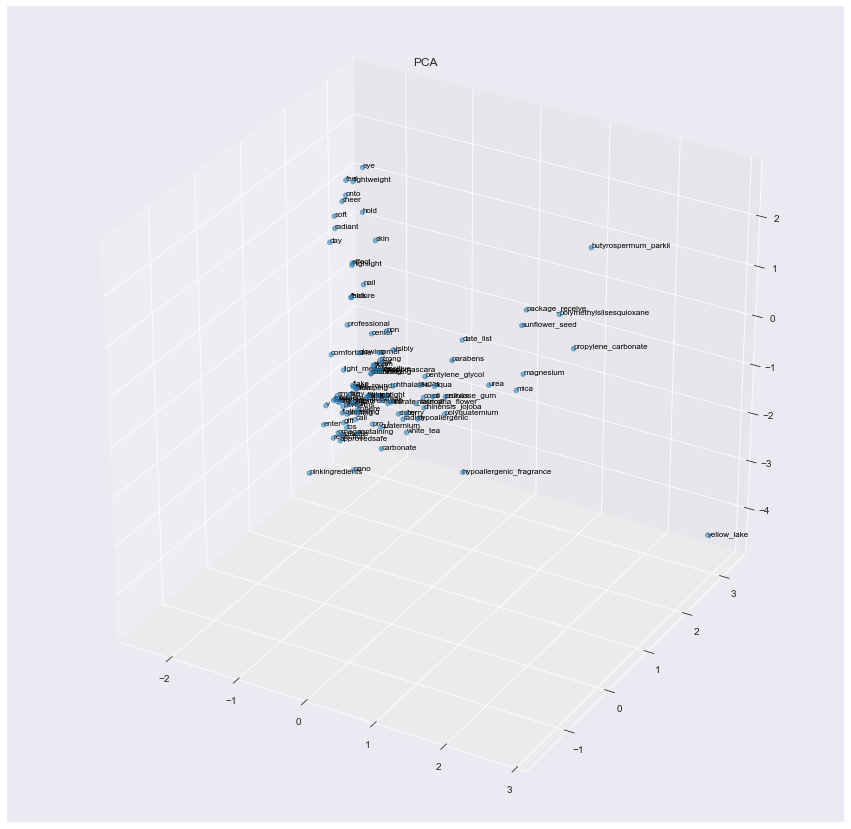

In [61]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=8, zorder=1, color='k')
    
plt.title('PCA')
plt.show()

#### TSNE

T-SNE is a useful tool to visualize high-dimensional data by dimension reduction while keeping relative pairwise distance between points. T-SNE looking for a new data representation where the neighborhood relations are preserved. 

In [62]:
tsne = TSNE(n_components=3, random_state=11)
tsne_result = tsne.fit_transform(X)

tmp = pd.DataFrame(tsne_result, index=vocab, columns=['x', 'y', 'z'])

tmp.head(3)

,x,y,z
lippie,-4.341869,5.552348,0.090714
pencil,-8.331988,17.812258,-8.053832
long_wearing,-5.802444,17.370501,-4.650693


In [92]:
tmp = tmp.sample(100)

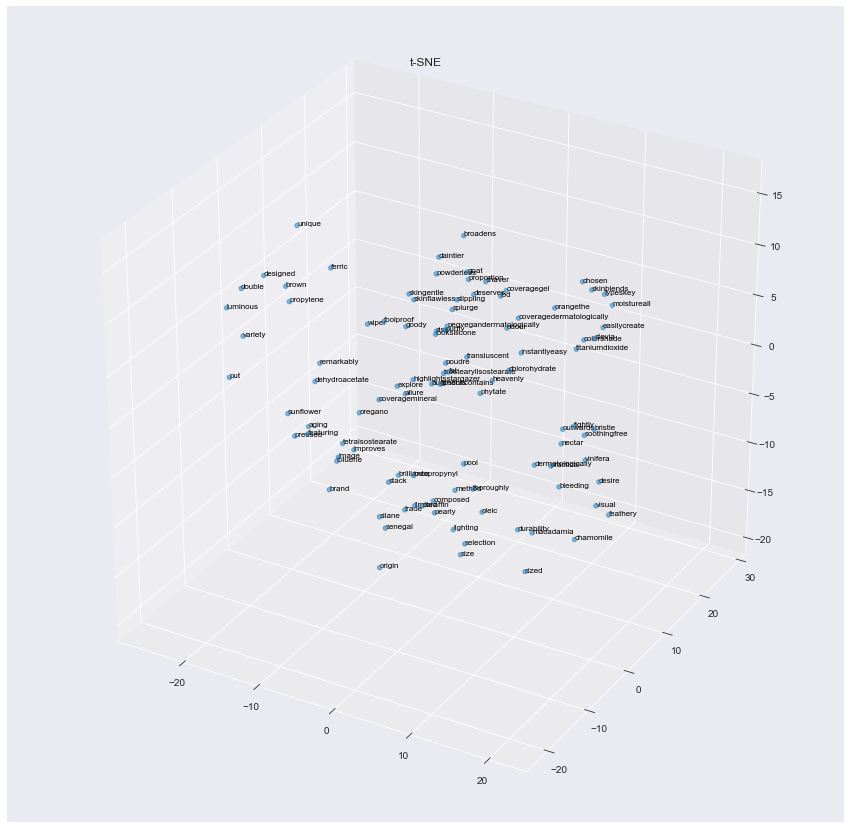

In [93]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=8, zorder=1, color='k')
    
plt.title('t-SNE')
plt.show()